### Import some stuff

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
!pip install scikit-image
from skimage.util import random_noise
import seaborn as sns

mnist = tf.keras.datasets.mnist

def show(image):
    plt.figure(figsize=(10,10))
    new = image.copy()
    if image.shape == 3:                    # Switch R and B channels so it shows up as correctly as R,G,B, if image is 3-channel
        new[:,:,0] = image[:,:,2]
        new[:,:,2] = image[:,:,0]
    plt.imshow(new, cmap = "gray")        # Using plt.imshow because cv2.imshow causes MemoryError

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


### Make a vanilla NN to train on MNIST. Note that y_train has been converted to one-hot-encoded vectors

In [ ]:
# Callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

# Load training and testing data
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert y_train to length 10 vectors
y_train_new = []
for value in y_train:
    vector = [0]*10
    vector[value] = 1
    y_train_new.append(vector)
y_train_new = np.array(y_train_new)

# Model from Coursera Tensorflow Developers Course 1
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train_new, epochs=10, callbacks=[myCallback()]);

Epoch 1/10
1875/1875 [==============================] - 20s 10ms/step - loss: 0.3413 - accuracy: 0.9007
Epoch 2/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0835 - accuracy: 0.9749
Epoch 3/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0496 - accuracy: 0.9850
Epoch 4/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0375 - accuracy: 0.9885
Epoch 5/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0249 - accuracy: 0.9920

Reached 99% accuracy so cancelling training!


### Check out model performance on test image

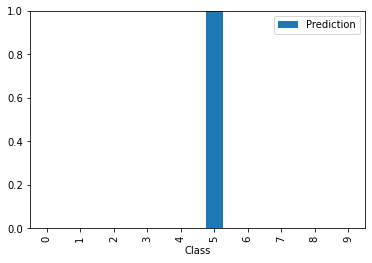

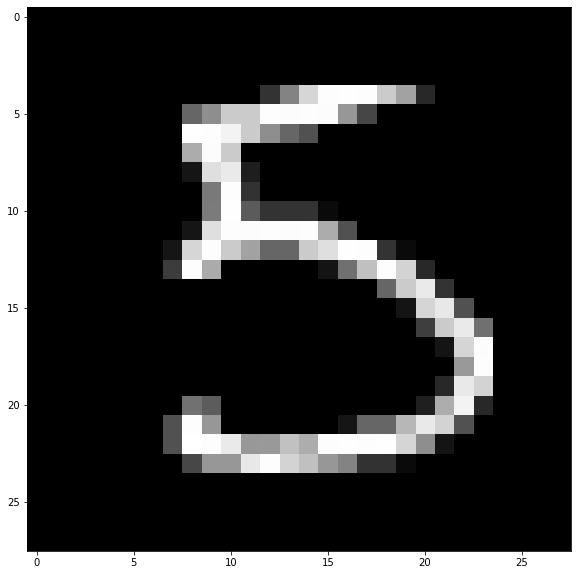

In [ ]:
# Select test image number
img_number = 15

# Model inference
img = x_test[img_number]
data = img.reshape(-1, img.shape[0], img.shape[1])

prediction = model.predict(data)[0]
df = pd.DataFrame({'Class': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'Prediction': prediction})

df.plot.bar(x='Class', y='Prediction', ylim=(0,1))
show(img)

### Make a pure noise out-of-domain (OOD) image and see what the model thinks

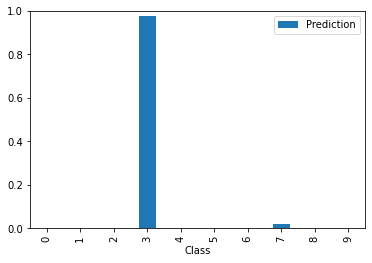

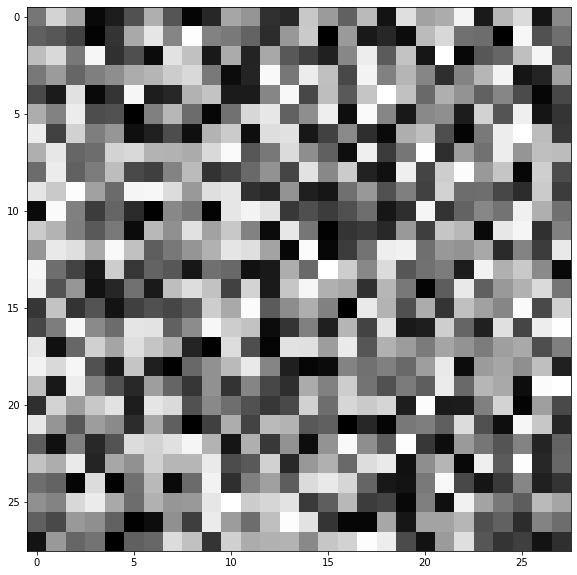

In [ ]:
# Create OOD image
ood = np.random.rand(28,28)
# ood = np.ones((28, 28))
# ood = np.zeros((28, 28))

# Model inference
img = ood
data = img.reshape(-1, img.shape[0], img.shape[1])

prediction = model.predict(data)[0]
df = pd.DataFrame({'Class': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'Prediction': prediction})

df.plot.bar(x='Class', y='Prediction', ylim=(0,1))
show(img)

### How does the model do on a noisy image?

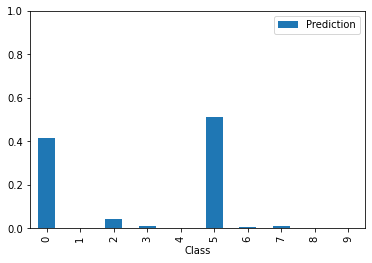

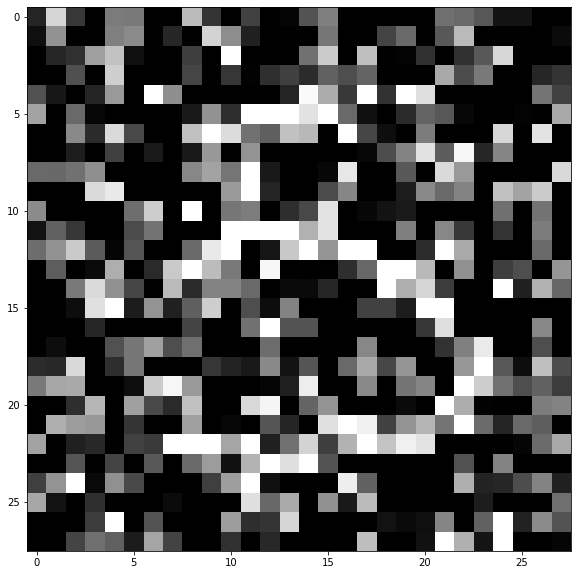

In [ ]:
# Select test image number
img_number = 15

# Model inference
img = x_test[img_number]

# Add some noise to image
img = random_noise(img, mode='gaussian', var=0.55**2)
data = img.reshape(-1, img.shape[0], img.shape[1])

prediction = model.predict(data)[0]
df = pd.DataFrame({'Class': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'Prediction': prediction})

df.plot.bar(x='Class', y='Prediction', ylim=(0,1))
show(img)

### Now train again, but with a whole bunch of pure noise images with equal activation. Training accuracy tops out at ~0.5 for some reason. I feel like something might be wrong with the output layer, and how the loss is computed. The model does pretty well though (see tests below)

In [ ]:
# Callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

# Load training and testing data
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert y_train to length 10 vectors
y_train_new = []
for value in y_train:
    vector = [0]*10
    vector[value] = 1
    y_train_new.append(vector)

# Append 60000 pure noise images to x_train and y_train
x_train = list(x_train)
for i in tqdm(range(60000)):
    x_train.append(np.random.rand(28,28))
    y_train_new.append([0.1]*10)

# Shuffle x_train and y_train together
temp = list(zip(x_train, y_train_new))
np.random.shuffle(temp)
x_train, y_train_new = zip(*temp)

# Convert to np arrays
x_train, y_train_new = np.array(x_train), np.array(y_train_new)

model_new = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model_new.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Limit to 3 epochs
model_new.fit(x_train, y_train_new, epochs=3, callbacks=[myCallback()]);

100%|██████████| 60000/60000 [00:01<00:00, 35342.26it/s]
Epoch 1/3
3750/3750 [==============================] - 28s 7ms/step - loss: 1.3106 - accuracy: 0.4762
Epoch 2/3
3750/3750 [==============================] - 31s 8ms/step - loss: 1.1907 - accuracy: 0.4980
Epoch 3/3
3750/3750 [==============================] - 39s 10ms/step - loss: 1.1713 - accuracy: 0.5553


### Like before, check out model performance on test image

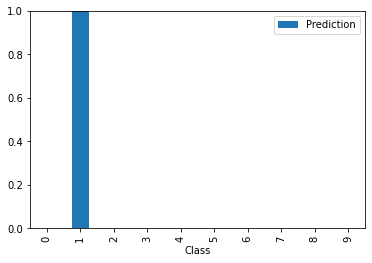

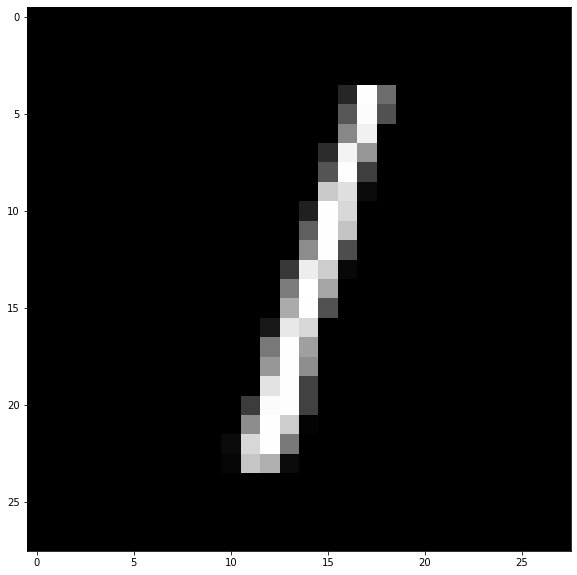

In [ ]:
# Select test image number
img_number = 2

# Model inference
img = x_test[img_number]
data = img.reshape(-1, img.shape[0], img.shape[1])

prediction = model_new.predict(data)[0]
df = pd.DataFrame({'Class': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'Prediction': prediction})

df.plot.bar(x='Class', y='Prediction', ylim=(0,1))
show(img)

### Like before, make OOD image and see what model thinks

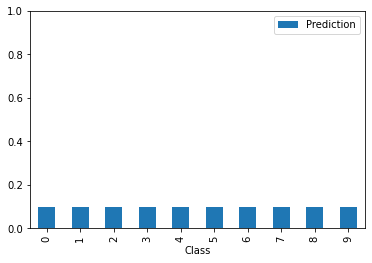

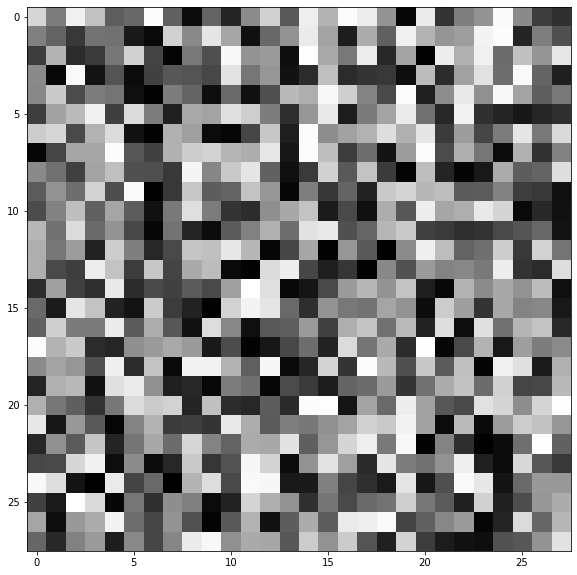

In [ ]:
# Create OOD image
ood = np.random.rand(28,28)
# ood = np.ones((28, 28))
# ood = np.zeros((28, 28))

# Model inference
img = ood
data = img.reshape(-1, img.shape[0], img.shape[1])

prediction = model_new.predict(data)[0]
df = pd.DataFrame({'Class': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'Prediction': prediction})

df.plot.bar(x='Class', y='Prediction', ylim=(0,1))
show(img)

### How does the model do on a noisy image? Compared with previous model

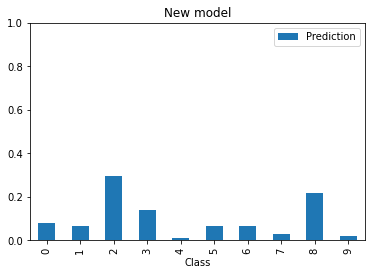

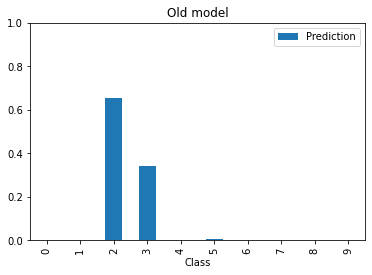

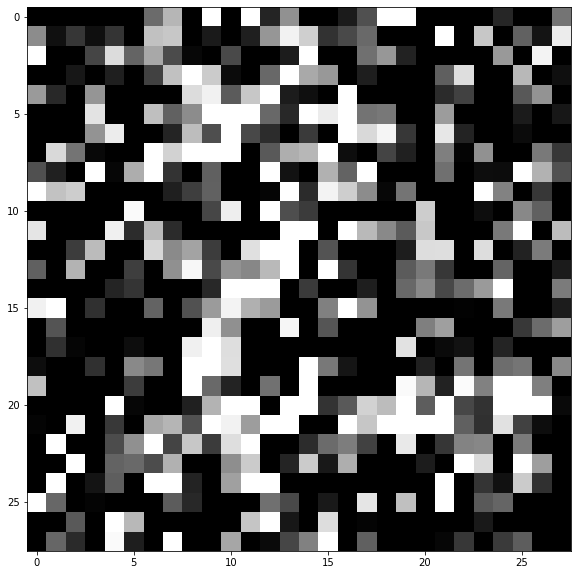

In [ ]:
# Select test image number
img_number = 1

# Model inference
img = x_test[img_number]

# Add some noise to image
img = random_noise(img, mode='gaussian', var=0.45)
data = img.reshape(-1, img.shape[0], img.shape[1])

prediction = model_new.predict(data)[0]
df = pd.DataFrame({'Class': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'Prediction': prediction})
df.plot.bar(x='Class', y='Prediction', ylim=(0,1), title='New model')

prediction = model.predict(data)[0]
df = pd.DataFrame({'Class': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'Prediction': prediction})
df.plot.bar(x='Class', y='Prediction', ylim=(0,1), title = 'Old model')

show(img)

### Let's take confidence to be the height of the tallest bar. How is confidence affected by increasing noise?

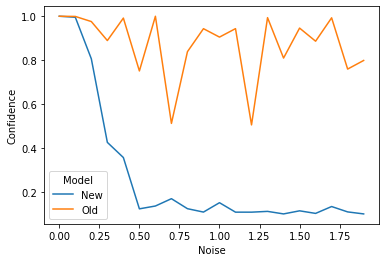

In [ ]:
# Select test image number
img_number = 1

# Model inference

new_model_confidences = []
old_model_confidences = []
noise_levels = []
img = x_test[img_number]

for noise in range(20):
    # Add some noise to image
    img_noise = random_noise(img, mode='gaussian', var=noise/10)
    data = img_noise.reshape(-1, img_noise.shape[0], img_noise.shape[1])

    new_prediction = model_new.predict(data)[0]
    new_model_confidences.append(new_prediction.max())

    old_prediction = model.predict(data)[0]
    old_model_confidences.append(old_prediction.max())

    noise_levels.append(noise/10)

df = pd.DataFrame({'Noise':noise_levels + noise_levels, 'Confidence':new_model_confidences + old_model_confidences, 'Model':['New']*len(new_model_confidences) + ['Old']*len(old_model_confidences)})
sns.lineplot(data = df, x='Noise', y='Confidence', hue = 'Model');


### So this is interesting because even though the training accuracy is low we get pretty much exactly what we want: A model that predicts actual numbers with high confidence and seems to deal with noisy images better. It also provides a more "uncertain" distribution for noisy images, and this could be potentially quantified as a measure of confidence.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f2dc94d7-bdba-4cca-bd94-69a815f4e540' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>